# Implementation of the u-network for segmentation

### Libraries

In [1]:
# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
from skimage.io import imread
from skimage.io import imshow
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, ConvTranspose2d
from torch.optim import Adam, SGD

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from collections import OrderedDict
from torch.nn import init

### Importing datas

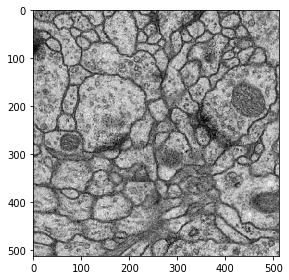

In [2]:
image = imread('EM_ISBI_Challenge/EM_ISBI_Challenge/train_images/train_01.Png')
imshow(image)

In [3]:
image.shape

(512, 512)

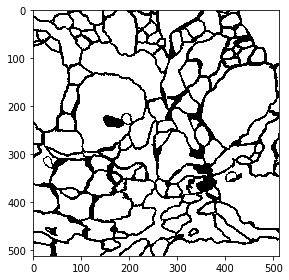

In [4]:
image_label = imread('EM_ISBI_Challenge/EM_ISBI_Challenge/train_labels/labels_01.png')
imshow(image_label)

In [5]:
image_label.shape

(512, 512)

In [6]:
nb_picture = 2

In [38]:
# loading training images
train_img = []
for nb_image in range(1,nb_picture+1):
    # defining the image path
    if nb_image<10:
        image_path = 'EM_ISBI_Challenge/EM_ISBI_Challenge/train_images/train_0{}.png'.format(nb_image) 
    if nb_image>=10:
        image_path = 'EM_ISBI_Challenge/EM_ISBI_Challenge/train_images/train_{}.png'.format(nb_image) 
    # reading the image
    img = imread(image_path, as_gray=True)
    # normalizing the pixel values
    img = img/255.0
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # appending the image into the list
    train_img.append(img)

labels_img = []
for nb_image in range(1,nb_picture+1):
    # defining the image path
    if nb_image<10:
        image_path = 'EM_ISBI_Challenge/EM_ISBI_Challenge/train_labels/labels_0{}.png'.format(nb_image) 
    if nb_image>=10:
        image_path = 'EM_ISBI_Challenge/EM_ISBI_Challenge/train_labels/labels_{}.png'.format(nb_image) 
    # reading the image
    img = imread(image_path, as_gray=True)
    # normalizing the pixel values
    img = img/255.0
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # appending the image into the list
    labels_img.append(img)

# converting the lists to numpy array
train_x = np.array(train_img)
label_x = np.array(labels_img)

print(train_x.shape)
print(label_x.shape)

(2, 512, 512)
(2, 512, 512)


In [39]:
# converting training images into torch format
train_x = train_x.reshape(nb_picture, 1, 512, 512)
train_x  = torch.from_numpy(train_x)

label_x = label_x.reshape(nb_picture, 512, 512)
label_x = torch.from_numpy(label_x)



## Architecture

### Simple CNN :

In [20]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.couche1 = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 64, kernel_size=3, stride=1, padding=0),
            ReLU(inplace=True),
            # Defining another 2D convolution layer
            Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
            ReLU(inplace=True),
        )

        self.pool = MaxPool2d(kernel_size=2, stride=2)

        self.couche2 = Sequential(
            # Defining a 2D convolution layer
            Conv2d(64,128, kernel_size=3, stride=1, padding=0),
            ReLU(inplace=True),
            # Defining another 2D convolution layer
            Conv2d(128, 128, kernel_size=3, stride=1, padding=0),
            ReLU(inplace=True),
        )

        self.upconv = Sequential(
            # Defining a 2D convolution layer
            ConvTranspose2d(128,64, kernel_size=2, stride=1, padding=1),
        )

        #self.linear_layers = Sequential(
        #    Linear(4 * 7 * 7, 10)
        #)

    # Defining the forward pass    
    def forward(self, x):
        x = self.couche1(x)
        x = self.pool(x)
        x = self.couche2(x)
        x = self.upconv(x)
        #x = self.linear_layers(x)
        return x

In [21]:
network = Net()

In [22]:
print(train_x.shape)
result = network(train_x)
result.shape

torch.Size([2, 1, 512, 512])


torch.Size([2, 64, 249, 249])

In [23]:
network = Net()
network(train_x)

tensor([[[[ 0.0746,  0.0769,  0.0736,  ...,  0.0778,  0.0773,  0.0782],
          [ 0.0751,  0.0789,  0.0765,  ...,  0.0783,  0.0760,  0.0747],
          [ 0.0743,  0.0767,  0.0797,  ...,  0.0782,  0.0763,  0.0751],
          ...,
          [ 0.0836,  0.0827,  0.0813,  ...,  0.0851,  0.0836,  0.0830],
          [ 0.0825,  0.0818,  0.0803,  ...,  0.0867,  0.0855,  0.0830],
          [ 0.0806,  0.0809,  0.0798,  ...,  0.0889,  0.0873,  0.0841]],

         [[-0.0558, -0.0552, -0.0564,  ..., -0.0577, -0.0557, -0.0544],
          [-0.0548, -0.0557, -0.0566,  ..., -0.0582, -0.0556, -0.0564],
          [-0.0547, -0.0552, -0.0541,  ..., -0.0567, -0.0559, -0.0550],
          ...,
          [-0.0564, -0.0576, -0.0570,  ..., -0.0576, -0.0604, -0.0605],
          [-0.0565, -0.0566, -0.0581,  ..., -0.0597, -0.0610, -0.0604],
          [-0.0572, -0.0564, -0.0580,  ..., -0.0585, -0.0595, -0.0595]],

         [[-0.0072, -0.0125, -0.0135,  ..., -0.0156, -0.0114, -0.0083],
          [-0.0111, -0.0112, -

### From https://github.com/jaxony/unet-pytorch

In [31]:
def conv3x3(in_channels, out_channels, stride=1, 
            padding=1, bias=True, groups=1):    
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=3,
        stride=stride,
        padding=padding,
        bias=bias,
        groups=groups)

def upconv2x2(in_channels, out_channels, mode='transpose'):
    if mode == 'transpose':
        return nn.ConvTranspose2d(
            in_channels,
            out_channels,
            kernel_size=2,
            stride=2)
    else:
        # out_channels is always going to be the same
        # as in_channels
        return nn.Sequential(
            nn.Upsample(mode='bilinear', scale_factor=2),
            conv1x1(in_channels, out_channels))

def conv1x1(in_channels, out_channels, groups=1):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=1,
        groups=groups,
        stride=1)


class DownConv(nn.Module):
    """
    A helper Module that performs 2 convolutions and 1 MaxPool.
    A ReLU activation follows each convolution.
    """
    def __init__(self, in_channels, out_channels, pooling=True):
        super(DownConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.pooling = pooling

        self.conv1 = conv3x3(self.in_channels, self.out_channels)
        self.conv2 = conv3x3(self.out_channels, self.out_channels)

        if self.pooling:
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        before_pool = x
        if self.pooling:
            x = self.pool(x)
        return x, before_pool


class UpConv(nn.Module):
    """
    A helper Module that performs 2 convolutions and 1 UpConvolution.
    A ReLU activation follows each convolution.
    """
    def __init__(self, in_channels, out_channels, 
                 merge_mode='concat', up_mode='transpose'):
        super(UpConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.merge_mode = merge_mode
        self.up_mode = up_mode

        self.upconv = upconv2x2(self.in_channels, self.out_channels, 
            mode=self.up_mode)

        if self.merge_mode == 'concat':
            self.conv1 = conv3x3(
                2*self.out_channels, self.out_channels)
        else:
            # num of input channels to conv2 is same
            self.conv1 = conv3x3(self.out_channels, self.out_channels)
        self.conv2 = conv3x3(self.out_channels, self.out_channels)


    def forward(self, from_down, from_up):
        """ Forward pass
        Arguments:
            from_down: tensor from the encoder pathway
            from_up: upconv'd tensor from the decoder pathway
        """
        from_up = self.upconv(from_up)
        if self.merge_mode == 'concat':
            x = torch.cat((from_up, from_down), 1)
        else:
            x = from_up + from_down
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x

In [10]:
down1 = DownConv(1,64)
result = down1(train_x)

print(result[0].shape)
result[1].shape

torch.Size([2, 64, 256, 256])


torch.Size([2, 64, 512, 512])

In [32]:
class UNet(nn.Module):
    """ `UNet` class is based on https://arxiv.org/abs/1505.04597
    The U-Net is a convolutional encoder-decoder neural network.
    Contextual spatial information (from the decoding,
    expansive pathway) about an input tensor is merged with
    information representing the localization of details
    (from the encoding, compressive pathway).
    Modifications to the original paper:
    (1) padding is used in 3x3 convolutions to prevent loss
        of border pixels
    (2) merging outputs does not require cropping due to (1)
    (3) residual connections can be used by specifying
        UNet(merge_mode='add')
    (4) if non-parametric upsampling is used in the decoder
        pathway (specified by upmode='upsample'), then an
        additional 1x1 2d convolution occurs after upsampling
        to reduce channel dimensionality by a factor of 2.
        This channel halving happens with the convolution in
        the tranpose convolution (specified by upmode='transpose')
    """

    def __init__(self, num_classes, in_channels=1, depth=5, 
                 start_filts=64, up_mode='transpose', 
                 merge_mode='concat'):
        """
        Arguments:
            in_channels: int, number of channels in the input tensor.
                Default is 3 for RGB images.
            depth: int, number of MaxPools in the U-Net.
            start_filts: int, number of convolutional filters for the 
                first conv.
            up_mode: string, type of upconvolution. Choices: 'transpose'
                for transpose convolution or 'upsample' for nearest neighbour
                upsampling.
        """
        super(UNet, self).__init__()

        if up_mode in ('transpose', 'upsample'):
            self.up_mode = up_mode
        else:
            raise ValueError("\"{}\" is not a valid mode for "
                             "upsampling. Only \"transpose\" and "
                             "\"upsample\" are allowed.".format(up_mode))
    
        if merge_mode in ('concat', 'add'):
            self.merge_mode = merge_mode
        else:
            raise ValueError("\"{}\" is not a valid mode for"
                             "merging up and down paths. "
                             "Only \"concat\" and "
                             "\"add\" are allowed.".format(up_mode))

        # NOTE: up_mode 'upsample' is incompatible with merge_mode 'add'
        if self.up_mode == 'upsample' and self.merge_mode == 'add':
            raise ValueError("up_mode \"upsample\" is incompatible "
                             "with merge_mode \"add\" at the moment "
                             "because it doesn't make sense to use "
                             "nearest neighbour to reduce "
                             "depth channels (by half).")

        self.num_classes = num_classes
        self.in_channels = in_channels
        self.start_filts = start_filts
        self.depth = depth

        self.down_convs = []
        self.up_convs = []

        # create the encoder pathway and add to a list
        for i in range(depth):
            ins = self.in_channels if i == 0 else outs
            outs = self.start_filts*(2**i)
            pooling = True if i < depth-1 else False

            down_conv = DownConv(ins, outs, pooling=pooling)
            self.down_convs.append(down_conv)

        # create the decoder pathway and add to a list
        # - careful! decoding only requires depth-1 blocks
        for i in range(depth-1):
            ins = outs
            outs = ins // 2
            up_conv = UpConv(ins, outs, up_mode=up_mode,
                merge_mode=merge_mode)
            self.up_convs.append(up_conv)

        self.conv_final = conv1x1(outs, self.num_classes)

        # add the list of modules to current module
        self.down_convs = nn.ModuleList(self.down_convs)
        self.up_convs = nn.ModuleList(self.up_convs)

        self.reset_params()

    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Conv2d):
            init.xavier_normal(m.weight)
            init.constant(m.bias, 0)


    def reset_params(self):
        for i, m in enumerate(self.modules()):
            self.weight_init(m)


    def forward(self, x):
        encoder_outs = []
        print('Going down')
        # encoder pathway, save outputs for merging
        for i, module in enumerate(self.down_convs):
            x, before_pool = module(x)
            print('After maxpool')
            print(x.shape)
            print('Stored array')
            print(before_pool.shape)
            encoder_outs.append(before_pool)
        print('Going up')
        for i, module in enumerate(self.up_convs):
            before_pool = encoder_outs[-(i+2)]
            print('After going up')
            x = module(before_pool, x)
            print(x.shape)
        
        # No softmax is used. This means you need to use
        # nn.CrossEntropyLoss is your training script,
        # as this module includes a softmax already.
        x = self.conv_final(x)
        return x

In [46]:
network = UNet(2)
result = network(train_x)

D:\anaconda3\envs\first_env\lib\site-packages\ipykernel_launcher.py:98: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
D:\anaconda3\envs\first_env\lib\site-packages\ipykernel_launcher.py:99: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.


Going down
After maxpool
torch.Size([2, 64, 256, 256])
Stored array
torch.Size([2, 64, 512, 512])
After maxpool
torch.Size([2, 128, 128, 128])
Stored array
torch.Size([2, 128, 256, 256])
After maxpool
torch.Size([2, 256, 64, 64])
Stored array
torch.Size([2, 256, 128, 128])
After maxpool
torch.Size([2, 512, 32, 32])
Stored array
torch.Size([2, 512, 64, 64])
After maxpool
torch.Size([2, 1024, 32, 32])
Stored array
torch.Size([2, 1024, 32, 32])
Going up
After going up
torch.Size([2, 512, 64, 64])
After going up
torch.Size([2, 256, 128, 128])
After going up
torch.Size([2, 128, 256, 256])
After going up
torch.Size([2, 64, 512, 512])


In [47]:
result.shape

torch.Size([2, 2, 512, 512])

In [48]:
m = nn.Softmax(dim=1)
result_soft =m(result)

In [53]:
print(result_soft.shape)
result_soft[0][:,1,1]

torch.Size([2, 2, 512, 512])


tensor([0.4915, 0.5085], grad_fn=<SelectBackward0>)

In [50]:
label_x.shape

torch.Size([2, 512, 512])

In [51]:
loss = nn.CrossEntropyLoss()

In [55]:
output = loss(result_soft, label_x.long())
output.backward()